# Notebook overview

This is an additional notebook in support to 01_Training.ipynb where we will be exploring several points related to our data:

1. Memory usage and how we can optimize it
2. Selection of the most relevant features by different techniques:
   - EDA
   - feature importance obtained by different algorithmes
  
It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

# Imports

## Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc, warnings, os, time
import importlib
import phik

# custom classes
import pipelines
import data_preprocessing as process
import transformers

importlib.reload(process)
importlib.reload(transformers)
importlib.reload(pipelines)

from pipelines import PIPELINES

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

warnings.simplefilter('ignore', category=FutureWarning)

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

In [11]:
def union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

## Data

We will load the main Application table, join all other tables with the basic feature engineering as intended for the training part.

In [12]:
data = process.load_application(dev_mode=False)
data.shape

(307511, 122)

In [13]:
dev_mode = False

X_bureau_features = process.get_bureau_and_balance_features(dev_mode=dev_mode)
X_prev_app_features = process.get_previous_applications_features(dev_mode=dev_mode)
X_pos_cash_balance_features = process.get_pos_cash_balance_features(dev_mode=dev_mode)
X_installment_features = process.get_installments_payments_features(dev_mode=dev_mode)
X_cc_balance_features = process.get_credit_card_balance_features(dev_mode=dev_mode)

fe_pipeline = Pipeline(steps=[
    ('cleaner', transformers.ApplicationCleaner()),
    ('feature_extractor', transformers.ApplicationFeaturesExtractor()),
    ('merge_bureau_and_balance', transformers.ApplicationFeaturesMerger(X_bureau_features)),
    ('merge_previous_applications', transformers.ApplicationFeaturesMerger(X_prev_app_features)),
    ('merge_pos_cash_balance', transformers.ApplicationFeaturesMerger(X_pos_cash_balance_features)),
    ('merge_installments_payments', transformers.ApplicationFeaturesMerger(X_installment_features)),
    ('merge_credit_card_balance', transformers.ApplicationFeaturesMerger(X_cc_balance_features)),
    ('oh_encoder', transformers.ApplicationEncoder())
])

data_transformed = fe_pipeline.fit_transform(data)
data_transformed.shape

(307511, 789)

In [14]:
del data, X_bureau_features, X_prev_app_features, X_pos_cash_balance_features, X_installment_features, X_cc_balance_features
gc.collect()

50

# Memory usage

Pandas by default stores the integer values as int64 and float values as float64. This actually takes a lot of memory. Instead, we can downcast the data types to smaller types. We should also check features having only 0 or 1 values encoded as float to transform them to uint8.

The limit of this approach is the presence of the NaN values, the downcasting will not be efficient on the columns having NaN values as they will upcast the existing values

In [15]:
data_transformed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 789 columns):
 #    Column                                                                 Dtype  
---   ------                                                                 -----  
 0    NAME_CONTRACT_TYPE_Cash loans                                          float64
 1    NAME_CONTRACT_TYPE_Revolving loans                                     float64
 2    CODE_GENDER_F                                                          float64
 3    CODE_GENDER_M                                                          float64
 4    CODE_GENDER_Unknown                                                    float64
 5    NAME_TYPE_SUITE_Children                                               float64
 6    NAME_TYPE_SUITE_Family                                                 float64
 7    NAME_TYPE_SUITE_Group of people                                        float64
 8    NAME_TYPE_SUITE_Other_A         

The dataset takes 1.8 GB in memory, and most part (747 out of 789) of the values is stored in float64 format. Let's see if we can optimize the dataset size.

In [16]:
def display_memory_by_dtype(dtype):
    selected_dtype = data_transformed.select_dtypes(include = [dtype])
    total_usage = selected_dtype.memory_usage(deep=True).sum()
    print("Total memory usage for {} columns: {:03.4f} MB".format(dtype, (total_usage / 1024) / 1024))

In [17]:
for dtype in ('float64', 'int64'):
    display_memory_by_dtype(dtype)

Total memory usage for float64 columns: 1752.5538 MB
Total memory usage for int64 columns: 98.5373 MB


## Downcast binary values

Let's get all the features having 0/1 values and convert them to int8

In [18]:
binary_features = data_transformed.columns[data_transformed.isin([0, 1]).all()]
binary_features.size

174

In [19]:
binary_features

Index(['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans',
       'CODE_GENDER_F', 'CODE_GENDER_M', 'CODE_GENDER_Unknown',
       'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family',
       'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A',
       'NAME_TYPE_SUITE_Other_B',
       ...
       'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21'],
      dtype='object', length=174)

In [20]:
data_transformed[binary_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 174 entries, NAME_CONTRACT_TYPE_Cash loans to FLAG_DOCUMENT_21
dtypes: float64(139), int64(35)
memory usage: 408.2 MB


We see that some binary values are stored in float64 and others in int64 and they occupy more than 400 MB.

In [21]:
for feature in binary_features:
    data_transformed[feature] = data_transformed[feature].astype("uint8")

data_transformed[binary_features].memory_usage(deep=True)

Index                                    128
NAME_CONTRACT_TYPE_Cash loans         307511
NAME_CONTRACT_TYPE_Revolving loans    307511
CODE_GENDER_F                         307511
CODE_GENDER_M                         307511
                                       ...  
FLAG_DOCUMENT_17                      307511
FLAG_DOCUMENT_18                      307511
FLAG_DOCUMENT_19                      307511
FLAG_DOCUMENT_20                      307511
FLAG_DOCUMENT_21                      307511
Length: 175, dtype: int64

In [22]:
data_transformed[binary_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 174 entries, NAME_CONTRACT_TYPE_Cash loans to FLAG_DOCUMENT_21
dtypes: uint8(174)
memory usage: 51.0 MB


The memory was reduced from 408.2 MB to 51 MB.

## Downcast integer values

The most part of the features is in int64 et float64 type, we'll use the pandas `.to_numeric()` function with the `downcast` argument that will automatically choose the smallest type for the given feature.

In [23]:
int_features = data_transformed.select_dtypes(['int64']).columns
int_features.size

7

In [24]:
data_transformed[int_features].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   SK_ID_CURR                   307511 non-null  int64
 1   CNT_CHILDREN                 307511 non-null  int64
 2   DAYS_BIRTH                   307511 non-null  int64
 3   DAYS_ID_PUBLISH              307511 non-null  int64
 4   REGION_RATING_CLIENT         307511 non-null  int64
 5   REGION_RATING_CLIENT_W_CITY  307511 non-null  int64
 6   HOUR_APPR_PROCESS_START      307511 non-null  int64
dtypes: int64(7)
memory usage: 16.4 MB


In [25]:
for feature in int_features:
    data_transformed[feature] = pd.to_numeric(data_transformed[feature], downcast='integer')

data_transformed[int_features].memory_usage(deep=True)

Index                              128
SK_ID_CURR                     1230044
CNT_CHILDREN                    307511
DAYS_BIRTH                      615022
DAYS_ID_PUBLISH                 615022
REGION_RATING_CLIENT            307511
REGION_RATING_CLIENT_W_CITY     307511
HOUR_APPR_PROCESS_START         307511
dtype: int64

In [26]:
data_transformed[int_features].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 7 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   SK_ID_CURR                   307511 non-null  int32
 1   CNT_CHILDREN                 307511 non-null  int8 
 2   DAYS_BIRTH                   307511 non-null  int16
 3   DAYS_ID_PUBLISH              307511 non-null  int16
 4   REGION_RATING_CLIENT         307511 non-null  int8 
 5   REGION_RATING_CLIENT_W_CITY  307511 non-null  int8 
 6   HOUR_APPR_PROCESS_START      307511 non-null  int8 
dtypes: int16(2), int32(1), int8(4)
memory usage: 3.5 MB


Downcasting integer values allowed to reduce the size occupied by this type from 16.4 MB to 3.5 MB.

## Downcast float values

In [27]:
float_features = data_transformed.select_dtypes(['float64']).columns
float_features.size

608

In [28]:
data_transformed[float_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 608 entries, AMT_INCOME_TOTAL to CC_COUNT
dtypes: float64(608)
memory usage: 1.4 GB


In [29]:
for feature in float_features:
    data_transformed[feature] = pd.to_numeric(data_transformed[feature], downcast='float')

data_transformed[float_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 608 entries, AMT_INCOME_TOTAL to CC_COUNT
dtypes: float32(448), float64(160)
memory usage: 900.9 MB


**Final result**

In [30]:
data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 789 entries, NAME_CONTRACT_TYPE_Cash loans to CC_COUNT
dtypes: float32(448), float64(160), int16(2), int32(1), int8(4), uint8(174)
memory usage: 955.5 MB


We went from 1.8 GB to 955.5 MB that represents almost 47% of memory reduction.

# Low variance features

Variance threshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold as it is assumed that features with a higher variance may contain more useful information

We will use scikit-learn `VarianceThreshold` feature selector that removes all low-variance features.

Passing a value of zero for the threshold parameter will filter all the features with zero variance i.e constant features. Quasi-constant features, as the name suggests, are the features that are almost constant. Such features are not very useful for making predictions. There is no rule as to what should be the threshold for the variance of quasi-constant features.

We will try to remove the quasi-constant features that have more than 90% similar values for the output observations.

Thus, instead of passing 0 as the value for the threshold parameter, we will pass 0.1, which means that if the variance of the values in a column is less than 0.1, remove that column. In other words, remove feature column where approximately 90% of the values are similar.

In [31]:
X_features = data_transformed.drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)

variance_filter = VarianceThreshold(threshold = 0.1)

data_with_variance = variance_filter.fit_transform(X_features)
print(data_with_variance.shape)

(307511, 352)


Extract all constant columns using get support function of our filter

In [32]:
constant_columns = [column for column in X_features.columns
                    if column not in X_features.columns[variance_filter.get_support()]]

print(len(constant_columns))

435


In [33]:
constant_columns

['NAME_CONTRACT_TYPE_Cash loans',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'CODE_GENDER_Unknown',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_Spouse, partner',
 'NAME_TYPE_SUITE_nan',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Unknown',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_HOUSING_TYPE_Co-op apartment',
 'NAME_HOUSING_TYPE_House / apartment',
 'NAME_HOUSING_TYPE_Municipal apartment',
 'NAME_HOUSING_TYPE_Office apartment',
 'NAME_HOUSING_TYPE_Rented apartment',
 'NAME_HOUSING_TYPE_With parents',
 'OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE_Cleaning staff',
 'O

In [34]:
columns_with_variance = list(data_with_variance.columns)
columns_with_variance

['CODE_GENDER_F',
 'CODE_GENDER_M',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Single / not married',
 'OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_nan',
 'WEEKDAY_APPR_PROCESS_START_FRIDAY',
 'WEEKDAY_APPR_PROCESS_START_MONDAY',
 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
 'ORGANIZATION_TYPE_Business Entity Type 3',
 'ORGANIZATION_TYPE_Self-employed',
 'ORGANIZATION_TYPE_Unknown',
 'FONDKAPREMONT_MODE_reg oper account',
 'FONDKAPREMONT_MODE_nan',
 'HOUSETYPE_MODE_block of flats',
 'HOUSETYPE_MODE_nan',
 'WALLSMATERIAL_MODE_Panel',
 'WALLSMATERIAL_MODE_Stone, brick',
 'WALLSMATERIAL_MODE_nan',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 

# Correlated features

Find correlated and negatively correlated features, with TARGET and between themselves, perform on the filtered by low variance dataframe

## Correlations


In [59]:
filtered_columns = columns_with_variance + ['TARGET']

**Normalize distribution**

PowerTransformer with automatically scale the data too.

In [60]:
binary_filtered = data_transformed[filtered_columns].columns[data_transformed[filtered_columns].isin([0, 1]).all()]
cont_features = [col for col in filtered_columns if col not in binary_filtered]

power_transformer = ColumnTransformer(transformers=[('normalizer', PowerTransformer(), cont_features)], 
                                remainder='passthrough',
                                verbose_feature_names_out=False)

X_normalized = power_transformer.fit_transform(data_transformed[filtered_columns])
X_normalized.head(10)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,WALLSMATERIAL_MODE_nan,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,TARGET
0,-0.6531,0.6475,-0.2840,0.0269,-0.3243,1.5975,0.8462,0.1711,0.5538,NaN,...,0,0,1,1,0,1,0,0,1,1
1,-0.6531,1.2127,1.4954,0.7446,1.4336,-0.2228,0.2955,1.1226,1.8377,NaN,...,0,0,0,1,0,1,0,0,1,0
2,-0.6531,-1.6558,-1.6483,-2.0819,-1.5338,-0.7166,1.6497,-0.0071,0.2812,1.3047,...,1,1,1,1,1,1,0,0,0,0
3,-0.6531,-0.1753,-0.6357,0.3779,-0.5495,-0.7079,-0.6468,-1.2451,0.3432,NaN,...,1,0,1,1,0,0,0,0,1,0
4,-0.6531,-0.3942,0.0424,-0.1981,0.2105,-0.9015,-0.6464,-0.0213,-0.3227,NaN,...,1,0,1,1,0,0,1,1,0,0
5,-0.6531,-0.8259,-0.0218,0.2313,0.0363,-0.2619,0.0195,-0.1983,1.6971,NaN,...,1,0,1,1,1,1,0,0,1,0
6,1.4572,0.3082,1.8233,1.0453,1.7881,0.4697,-0.6787,1.1082,1.5925,0.7646,...,1,1,1,1,0,1,0,0,0,0
7,-0.6531,1.7629,1.7880,1.0843,1.9471,-0.6752,1.1316,-0.0997,0.3816,-0.1049,...,1,1,1,1,1,0,1,1,1,0
8,-0.6531,-0.5555,1.0966,0.6359,1.0892,-0.9359,NaN,-0.7713,-0.3587,NaN,...,1,0,1,0,0,0,0,0,1,0
9,-0.6531,-0.1753,-0.2894,-0.3367,-0.1265,0.3042,-0.2189,-2.0105,-0.6650,NaN,...,1,0,1,1,0,0,0,0,0,0


In [61]:
correlations = X_normalized.corr().abs()
correlations

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,WALLSMATERIAL_MODE_nan,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,TARGET
CNT_CHILDREN,1.0000,0.0404,0.0008,0.0223,0.0026,0.3567,0.0424,0.1715,0.0111,0.0088,...,0.0194,0.1063,0.0058,0.2710,0.0489,0.0361,0.0741,0.0688,0.0607,0.0203
AMT_INCOME_TOTAL,0.0404,1.0000,0.4245,0.4889,0.4298,0.0910,0.0589,0.0791,0.0368,0.2000,...,0.1336,0.2258,0.0086,0.2078,0.0541,0.0114,0.0395,0.0394,0.0096,0.0179
AMT_CREDIT,0.0008,0.4245,1.0000,0.8349,0.9889,0.0629,0.0992,0.0138,0.0037,0.1009,...,0.0502,0.1139,0.0422,0.0724,0.0350,0.0161,0.0143,0.0047,0.1163,0.0164
AMT_ANNUITY,0.0223,0.4889,0.8349,1.0000,0.8360,0.0002,0.0719,0.0386,0.0117,0.0998,...,0.0591,0.1411,0.0110,0.1111,0.0316,0.0055,0.0062,0.0164,0.1451,0.0022
AMT_GOODS_PRICE,0.0026,0.4298,0.9889,0.8360,1.0000,0.0595,0.1014,0.0154,0.0046,0.1133,...,0.0554,0.1184,0.0471,0.0719,0.0139,0.0321,0.0156,0.0036,0.0881,0.0260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FLAG_PHONE,0.0361,0.0114,0.0161,0.0055,0.0321,0.0431,0.0556,0.0811,0.0376,0.0577,...,0.0669,0.0076,0.0415,0.0161,0.2931,1.0000,0.0457,0.0236,0.0080,0.0238
REG_CITY_NOT_WORK_CITY,0.0741,0.0395,0.0143,0.0062,0.0156,0.2400,0.1301,0.0830,0.0985,0.0314,...,0.2592,0.0761,0.0619,0.2564,0.1210,0.0457,1.0000,0.8256,0.0563,0.0510
LIVE_CITY_NOT_WORK_CITY,0.0688,0.0394,0.0047,0.0164,0.0036,0.1539,0.0720,0.0623,0.0606,0.0256,...,0.2001,0.0881,0.0360,0.2192,0.1099,0.0236,0.8256,1.0000,0.0539,0.0325
FLAG_DOCUMENT_3,0.0607,0.0096,0.1163,0.1451,0.0881,0.0993,0.0493,0.0262,0.0497,0.0455,...,0.0307,0.0700,0.0368,0.2485,0.0603,0.0080,0.0563,0.0539,1.0000,0.0443


**Mask duplicates**

In [62]:
correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype('bool'))
correlations

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,WALLSMATERIAL_MODE_nan,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,TARGET
CNT_CHILDREN,NaN,0.0404,0.0008,0.0223,0.0026,0.3567,0.0424,0.1715,0.0111,0.0088,...,0.0194,0.1063,0.0058,0.2710,0.0489,0.0361,0.0741,0.0688,0.0607,0.0203
AMT_INCOME_TOTAL,NaN,NaN,0.4245,0.4889,0.4298,0.0910,0.0589,0.0791,0.0368,0.2000,...,0.1336,0.2258,0.0086,0.2078,0.0541,0.0114,0.0395,0.0394,0.0096,0.0179
AMT_CREDIT,NaN,NaN,NaN,0.8349,0.9889,0.0629,0.0992,0.0138,0.0037,0.1009,...,0.0502,0.1139,0.0422,0.0724,0.0350,0.0161,0.0143,0.0047,0.1163,0.0164
AMT_ANNUITY,NaN,NaN,NaN,NaN,0.8360,0.0002,0.0719,0.0386,0.0117,0.0998,...,0.0591,0.1411,0.0110,0.1111,0.0316,0.0055,0.0062,0.0164,0.1451,0.0022
AMT_GOODS_PRICE,NaN,NaN,NaN,NaN,NaN,0.0595,0.1014,0.0154,0.0046,0.1133,...,0.0554,0.1184,0.0471,0.0719,0.0139,0.0321,0.0156,0.0036,0.0881,0.0260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FLAG_PHONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0457,0.0236,0.0080,0.0238
REG_CITY_NOT_WORK_CITY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8256,0.0563,0.0510
LIVE_CITY_NOT_WORK_CITY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0539,0.0325
FLAG_DOCUMENT_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0443


**Verify correlations with target**

In [63]:
correlations.sort_values('TARGET', ascending=False)['TARGET'][:30]

CC_CNT_DRAWINGS_CURRENT_VAR        0.1295
CC_CNT_DRAWINGS_CURRENT_MEAN       0.1288
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN   0.1184
CC_CNT_DRAWINGS_CURRENT_MAX        0.1117
CC_CNT_DRAWINGS_ATM_CURRENT_VAR    0.1095
CC_AMT_DRAWINGS_CURRENT_MEAN       0.0998
BUREAU_DAYS_CREDIT_MEAN            0.0957
CC_CNT_DRAWINGS_CURRENT_SUM        0.0941
CC_AMT_DRAWINGS_CURRENT_VAR        0.0918
BUREAU_MONTHS_BALANCE_SIZE_MEAN    0.0896
CC_AMT_BALANCE_MEAN                0.0889
CC_AMT_TOTAL_RECEIVABLE_MEAN       0.0882
CC_AMT_RECIVABLE_MEAN              0.0882
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN   0.0880
CC_AMT_INST_MIN_REGULARITY_MEAN    0.0878
CC_CNT_DRAWINGS_POS_CURRENT_SUM    0.0873
CC_CNT_DRAWINGS_POS_CURRENT_VAR    0.0837
CC_AMT_BALANCE_MAX                 0.0812
BUREAU_DAYS_CREDIT_UPDATE_MEAN     0.0811
CC_AMT_INST_MIN_REGULARITY_VAR     0.0810
CC_AMT_TOTAL_RECEIVABLE_MAX        0.0804
CC_AMT_RECIVABLE_MAX               0.0804
ACTIVE_DAYS_CREDIT_MAX             0.0803
CC_AMT_RECEIVABLE_PRINCIPAL_MAX   

We don't observe any strong correlated variables with the TARGET.

**Get features correlated more or equal than 0.7**

In [64]:
high_correlations = correlations[correlations >= 0.7].stack().reset_index()
high_correlations.sort_values(by=0, ascending=False).head(20)

,level_0,level_1,0
132,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,1.0000
453,POS_MONTHS_BALANCE_SIZE,POS_COUNT,1.0000
1096,CC_CNT_DRAWINGS_OTHER_CURRENT_MAX,CC_CNT_DRAWINGS_OTHER_CURRENT_SUM,1.0000
754,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,1.0000
767,CC_AMT_DRAWINGS_POS_CURRENT_MIN,CC_CNT_DRAWINGS_POS_CURRENT_MIN,1.0000
755,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,1.0000
762,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,1.0000
1017,CC_AMT_RECIVABLE_MIN,CC_AMT_TOTAL_RECEIVABLE_MIN,1.0000
110,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,1.0000
1038,CC_AMT_RECIVABLE_VAR,CC_AMT_TOTAL_RECEIVABLE_VAR,1.0000


Keep level 0 features and drop level 1 features

In [65]:
high_correlations[['level_0', 'level_1']].nunique()

level_0    231
level_1    232
dtype: int64

In [66]:
high_correlations['level_0'].unique()

array(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'INCOME_PER_PERSON', 'BUREAU_DAYS_CREDIT_MIN',
       'BUREAU_DAYS_CREDIT_MAX', 'BUREAU_DAYS_CREDIT_MEAN',
       'BUREAU_DAYS_CREDIT_VAR', 'BUREAU_DAYS_CREDIT_ENDDATE_MIN',
       'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
       'BUREAU_DAYS_CREDIT_ENDDATE_MEAN',
       'BUREAU_DAYS_CREDIT_UPDATE_MEAN', 'BUREAU_CREDIT_DAY_OVERDUE_MAX',
       'BUREAU_CREDIT_DAY_OVERDUE_MEAN',
       'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN', 'BUREAU_AMT_CREDIT_SUM_MAX',
       'BUREAU_AMT_CREDIT_SUM_MEAN', 'BUREAU_AMT_CREDIT_SUM_SUM',
       'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
       'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
       'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
       'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN',
       'BUREAU_AMT_CREDIT_SUM_LIMIT_SUM', 'BUREAU_AMT_ANNUITY_MAX',
       'BUREAU_A

In [67]:
corr_features_to_drop = high_correlations['level_1'].unique()
corr_features_to_drop

array(['CNT_FAM_MEMBERS', 'INCOME_PER_PERSON', 'INCOME_PER_CHILD',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'INCOME_CREDIT_PERC',
       'REGION_RATING_CLIENT_W_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'BUREAU_DAYS_CREDIT_MEAN',
       'BUREAU_DAYS_CREDIT_VAR', 'BUREAU_DAYS_CREDIT_UPDATE_MEAN',
       'BUREAU_MONTHS_BALANCE_MIN_MIN', 'CLOSED_DAYS_CREDIT_MIN',
       'CLOSED_DAYS_CREDIT_MEAN', 'CLOSED_MONTHS_BALANCE_MIN_MIN',
       'ACTIVE_DAYS_CREDIT_MAX', 'BUREAU_MONTHS_BALANCE_SIZE_MEAN',
       'CLOSED_DAYS_CREDIT_UPDATE_MEAN', 'CLOSED_DAYS_CREDIT_VAR',
       'CLOSED_DAYS_CREDIT_ENDDATE_MIN',
       'BUREAU_DAYS_CREDIT_ENDDATE_MEAN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
       'BUREAU_CREDIT_DAY_OVERDUE_MEAN',
       'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'ACTIVE_CREDIT_DAY_OVERDUE_MAX', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
       'CLOSED_AMT_CREDIT_MAX_OVERDU

In [68]:
non_corr_features = [col for col in filtered_columns if col not in corr_features_to_drop]
print(len(non_corr_features))
non_corr_features

121


['CODE_GENDER_F',
 'NAME_TYPE_SUITE_Family',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Single / not married',
 'OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_nan',
 'WEEKDAY_APPR_PROCESS_START_FRIDAY',
 'WEEKDAY_APPR_PROCESS_START_MONDAY',
 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
 'ORGANIZATION_TYPE_Business Entity Type 3',
 'ORGANIZATION_TYPE_Self-employed',
 'FONDKAPREMONT_MODE_reg oper account',
 'HOUSETYPE_MODE_block of flats',
 'WALLSMATERIAL_MODE_Panel',
 'WALLSMATERIAL_MODE_Stone, brick',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',

## Phi Coefficient

A Phi Coefficient (sometimes called a mean square contingency coefficient) is a measure of the association between two binary variables.

In [69]:
binary_filtered = data_transformed[filtered_columns].columns[data_transformed[filtered_columns].isin([0, 1]).all()]
len(binary_filtered)

37

Get the phi_k correlation matrix between binary variables

In [70]:
phi_coef = data_transformed[binary_filtered].phik_matrix()

interval columns not set, guessing: ['CODE_GENDER_F', 'CODE_GENDER_M', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Single / not married', 'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_nan', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'ORGANIZATION_TYPE_Business Entity Type 3', 'ORGANIZATION_TYPE_Self-employed', 'ORGANIZATION_TYPE_Unknown', 'FONDKAPREMONT_MODE_reg oper account', 'FONDKAPREMONT_MODE_nan', 'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_nan', 'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_nan', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_EMP_P

In [71]:
phi_coef

,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,...,WALLSMATERIAL_MODE_nan,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,TARGET
CODE_GENDER_F,1.0000,1.0000,0.0326,0.0118,0.0669,0.2445,0.1662,0.0250,0.0068,0.1535,...,0.0424,0.5169,0.0696,0.2445,0.0533,0.0304,0.2144,0.2078,0.1367,0.0858
CODE_GENDER_M,1.0000,1.0000,0.0326,0.0118,0.0669,0.2445,0.1661,0.0250,0.0068,0.1535,...,0.0425,0.5169,0.0696,0.2445,0.0532,0.0305,0.2144,0.2078,0.1366,0.0858
NAME_TYPE_SUITE_Family,0.0326,0.0326,1.0000,0.9488,0.0206,0.0497,0.0220,0.0391,0.0427,0.0936,...,0.0367,0.0000,0.0690,0.0495,0.0188,0.0201,0.0135,0.0051,0.0243,0.0126
NAME_TYPE_SUITE_Unaccompanied,0.0118,0.0118,0.9488,1.0000,0.0245,0.0421,0.0124,0.0561,0.0604,0.1267,...,0.0465,0.0140,0.0768,0.0418,0.0312,0.0194,0.0065,0.0114,0.0204,0.0127
NAME_INCOME_TYPE_Commercial associate,0.0669,0.0669,0.0206,0.0245,1.0000,0.3945,0.7797,0.1845,0.1899,0.0058,...,0.1087,0.0938,0.0147,0.3945,0.0157,0.0071,0.0776,0.0407,0.0056,0.0185
NAME_INCOME_TYPE_Pensioner,0.2445,0.2445,0.0497,0.0421,0.3945,1.0000,0.6892,0.1631,0.1686,0.0788,...,0.0152,0.2408,0.1099,1.0000,0.3588,0.0253,0.3919,0.3375,0.3803,0.0724
NAME_INCOME_TYPE_Working,0.1662,0.1661,0.0220,0.0124,0.7797,0.6892,1.0000,0.1162,0.1095,0.0396,...,0.0706,0.1055,0.0550,0.6893,0.2565,0.0261,0.2330,0.2188,0.2551,0.0901
NAME_EDUCATION_TYPE_Higher education,0.0250,0.0250,0.0391,0.0561,0.1845,0.1631,0.1162,1.0000,0.9846,0.0242,...,0.1632,0.1454,0.0239,0.1629,0.0043,0.0463,0.0373,0.0486,0.0893,0.0887
NAME_EDUCATION_TYPE_Secondary / secondary special,0.0068,0.0068,0.0427,0.0604,0.1899,0.1686,0.1095,0.9846,1.0000,0.0040,...,0.1579,0.1374,0.0400,0.1685,0.0126,0.0462,0.0240,0.0462,0.0951,0.0781
NAME_FAMILY_STATUS_Married,0.1535,0.1535,0.0936,0.1267,0.0058,0.0788,0.0396,0.0242,0.0040,1.0000,...,0.1051,0.2322,0.0278,0.0788,0.0450,0.0361,0.0177,0.0594,0.0392,0.0392


In [72]:
phi_coef = phi_coef.mask(np.tril(np.ones(phi_coef.shape)).astype('bool'))
phi_coef

,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,...,WALLSMATERIAL_MODE_nan,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_3,TARGET
CODE_GENDER_F,NaN,1.0000,0.0326,0.0118,0.0669,0.2445,0.1662,0.0250,0.0068,0.1535,...,0.0424,0.5169,0.0696,0.2445,0.0533,0.0304,0.2144,0.2078,0.1367,0.0858
CODE_GENDER_M,NaN,NaN,0.0326,0.0118,0.0669,0.2445,0.1661,0.0250,0.0068,0.1535,...,0.0425,0.5169,0.0696,0.2445,0.0532,0.0305,0.2144,0.2078,0.1366,0.0858
NAME_TYPE_SUITE_Family,NaN,NaN,NaN,0.9488,0.0206,0.0497,0.0220,0.0391,0.0427,0.0936,...,0.0367,0.0000,0.0690,0.0495,0.0188,0.0201,0.0135,0.0051,0.0243,0.0126
NAME_TYPE_SUITE_Unaccompanied,NaN,NaN,NaN,NaN,0.0245,0.0421,0.0124,0.0561,0.0604,0.1267,...,0.0465,0.0140,0.0768,0.0418,0.0312,0.0194,0.0065,0.0114,0.0204,0.0127
NAME_INCOME_TYPE_Commercial associate,NaN,NaN,NaN,NaN,NaN,0.3945,0.7797,0.1845,0.1899,0.0058,...,0.1087,0.0938,0.0147,0.3945,0.0157,0.0071,0.0776,0.0407,0.0056,0.0185
NAME_INCOME_TYPE_Pensioner,NaN,NaN,NaN,NaN,NaN,NaN,0.6892,0.1631,0.1686,0.0788,...,0.0152,0.2408,0.1099,1.0000,0.3588,0.0253,0.3919,0.3375,0.3803,0.0724
NAME_INCOME_TYPE_Working,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1162,0.1095,0.0396,...,0.0706,0.1055,0.0550,0.6893,0.2565,0.0261,0.2330,0.2188,0.2551,0.0901
NAME_EDUCATION_TYPE_Higher education,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9846,0.0242,...,0.1632,0.1454,0.0239,0.1629,0.0043,0.0463,0.0373,0.0486,0.0893,0.0887
NAME_EDUCATION_TYPE_Secondary / secondary special,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0040,...,0.1579,0.1374,0.0400,0.1685,0.0126,0.0462,0.0240,0.0462,0.0951,0.0781
NAME_FAMILY_STATUS_Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.1051,0.2322,0.0278,0.0788,0.0450,0.0361,0.0177,0.0594,0.0392,0.0392


In [73]:
phi_coef.sort_values('TARGET', ascending=False)['TARGET'][:30]

NAME_INCOME_TYPE_Working                            0.0901
NAME_EDUCATION_TYPE_Higher education                0.0887
CODE_GENDER_M                                       0.0858
CODE_GENDER_F                                       0.0858
REG_CITY_NOT_WORK_CITY                              0.0799
NAME_EDUCATION_TYPE_Secondary / secondary special   0.0781
NAME_INCOME_TYPE_Pensioner                          0.0724
ORGANIZATION_TYPE_Unknown                           0.0721
FLAG_EMP_PHONE                                      0.0721
FLAG_DOCUMENT_3                                     0.0695
OCCUPATION_TYPE_Laborers                            0.0674
HOUSETYPE_MODE_block of flats                       0.0636
HOUSETYPE_MODE_nan                                  0.0623
WALLSMATERIAL_MODE_nan                              0.0618
OCCUPATION_TYPE_nan                                 0.0607
WALLSMATERIAL_MODE_Panel                            0.0519
LIVE_CITY_NOT_WORK_CITY                             0.05

In [74]:
high_phi_coef = phi_coef[phi_coef >= 0.7].stack().reset_index()
high_phi_coef.sort_values(0, ascending=False)

,level_0,level_1,0
0,CODE_GENDER_F,CODE_GENDER_M,1.0000
10,ORGANIZATION_TYPE_Unknown,FLAG_EMP_PHONE,1.0000
4,NAME_INCOME_TYPE_Pensioner,ORGANIZATION_TYPE_Unknown,1.0000
5,NAME_INCOME_TYPE_Pensioner,FLAG_EMP_PHONE,1.0000
18,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_nan,0.9996
23,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_nan,0.9978
20,HOUSETYPE_MODE_block of flats,WALLSMATERIAL_MODE_nan,0.9958
6,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,0.9846
11,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_nan,0.9632
26,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,0.9627


In [75]:
high_phi_coef.shape

(27, 3)

In [76]:
high_phi_coef.nunique()

level_0    15
level_1    15
0          24
dtype: int64

In [77]:
phi_coef_level_0 = high_phi_coef['level_0'].unique()
high_correlations.loc[high_correlations['level_0'].isin(phi_coef_level_0), :].sort_values(0, ascending=False)

,level_0,level_1,0
1141,CODE_GENDER_F,CODE_GENDER_M,1.0000
1146,ORGANIZATION_TYPE_Unknown,FLAG_EMP_PHONE,0.9999
1143,NAME_INCOME_TYPE_Pensioner,ORGANIZATION_TYPE_Unknown,0.9996
1144,NAME_INCOME_TYPE_Pensioner,FLAG_EMP_PHONE,0.9995
1148,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_nan,0.9825
1150,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_nan,0.9577
1149,HOUSETYPE_MODE_block of flats,WALLSMATERIAL_MODE_nan,0.9418
1145,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Secondary / secondary special,0.8880
1147,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_nan,0.8267
1151,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,0.8256


In [78]:
phi_coef_level_1 = high_phi_coef['level_1'].unique()
phi_coef_level_1

array(['CODE_GENDER_M', 'NAME_TYPE_SUITE_Unaccompanied',
       'NAME_INCOME_TYPE_Working', 'OCCUPATION_TYPE_nan',
       'ORGANIZATION_TYPE_Unknown', 'FLAG_EMP_PHONE',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Single / not married',
       'FONDKAPREMONT_MODE_nan', 'HOUSETYPE_MODE_block of flats',
       'HOUSETYPE_MODE_nan', 'WALLSMATERIAL_MODE_nan',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'LIVE_CITY_NOT_WORK_CITY'], dtype=object)

In [79]:
high_correlations.loc[high_correlations['level_0'].isin(phi_coef_level_1), :].sort_values(0, ascending=False)

,level_0,level_1,0
1146,ORGANIZATION_TYPE_Unknown,FLAG_EMP_PHONE,0.9999
1148,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_nan,0.9825
1150,HOUSETYPE_MODE_nan,WALLSMATERIAL_MODE_nan,0.9577
1149,HOUSETYPE_MODE_block of flats,WALLSMATERIAL_MODE_nan,0.9418


In [80]:
intersection(non_corr_features, phi_coef_level_1)

['NAME_INCOME_TYPE_Working',
 'NAME_FAMILY_STATUS_Single / not married',
 'OCCUPATION_TYPE_nan',
 'HOUSETYPE_MODE_block of flats',
 'WALLSMATERIAL_MODE_Panel',
 'WALLSMATERIAL_MODE_Stone, brick']

In [81]:
common_corr_features = union(corr_features_to_drop, phi_coef_level_1)
print(len(common_corr_features))
common_corr_features

238


['CC_AMT_TOTAL_RECEIVABLE_VAR',
 'WALLSMATERIAL_MODE_Panel',
 'PREV_AMT_CREDIT_MIN',
 'CLOSED_DAYS_CREDIT_MIN',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
 'NAME_FAMILY_STATUS_Single / not married',
 'APPROVED_AMT_GOODS_PRICE_MEAN',
 'APPROVED_AMT_APPLICATION_MAX',
 'CNT_FAM_MEMBERS',
 'CC_AMT_RECIVABLE_VAR',
 'CC_AMT_DRAWINGS_CURRENT_MAX',
 'CLOSED_AMT_ANNUITY_MEAN',
 'ACTIVE_CREDIT_DAY_OVERDUE_MAX',
 'CC_AMT_RECIVABLE_MIN',
 'ACTIVE_AMT_ANNUITY_MAX',
 'REFUSED_AMT_CREDIT_MEAN',
 'CC_AMT_PAYMENT_CURRENT_SUM',
 'POS_SK_DPD_MEAN',
 'BUREAU_CREDIT_DAY_OVERDUE_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MIN',
 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_DEBT_SUM',
 'CLOSED_AMT_CREDIT_SUM_MAX',
 'REFUSED_HOUR_APPR_PROCESS_START_MAX',
 'CC_COUNT',
 'CC_CNT_DRAWINGS_CURRENT_MEAN',
 'CLOSED_DAYS_CREDIT_MEAN',
 'CC_SK_DPD_VAR',
 'LIVE_CITY_NOT_WORK_CITY',
 'BUREAU_DAYS_CREDIT_UPDATE_MEAN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
 'POS_SK_DPD_DEF_MEAN',
 'APPROVED_A

In [82]:
non_corr_features_common = [col for col in filtered_columns if col not in common_corr_features]
print(len(non_corr_features_common))
non_corr_features_common

115


['CODE_GENDER_F',
 'NAME_TYPE_SUITE_Family',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_FAMILY_STATUS_Married',
 'OCCUPATION_TYPE_Laborers',
 'WEEKDAY_APPR_PROCESS_START_FRIDAY',
 'WEEKDAY_APPR_PROCESS_START_MONDAY',
 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
 'ORGANIZATION_TYPE_Business Entity Type 3',
 'ORGANIZATION_TYPE_Self-employed',
 'FONDKAPREMONT_MODE_reg oper account',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_WORK_CITY',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'A

`non_corr_features_common` will be our final feature list after filtering with low variance and correlations

# PCA

Let's retry a PCA to see if we can further group features in components.

## Prepare data

Before proceeding, we have to impute missing values and scale the data

In [487]:
X_features = data_transformed[non_corr_features_common].drop(columns='TARGET', axis=1)
X_features.shape

(307511, 125)

In [488]:
X_binary = X_features.columns[X_features.isin([0, 1]).all()]
X_binary.size

21

In [489]:
X_cont = [col for col in X_features.columns if col not in X_binary]
X_cont

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT',
 'HOUR_APPR_PROCESS_START',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'BUREAU_DAYS_CREDIT_MIN',
 'BUREAU_DAYS_CREDIT_MAX',
 'BUREAU_DAYS_CREDIT_VAR',
 'BUREAU_DAYS_CREDIT_ENDDATE_MIN',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'BUREAU_CREDIT_DAY_OVERDUE_MAX',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_MAX',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
 'BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN',
 'BUREAU_AMT_ANNUITY_MAX',
 'BUREAU_MONTHS_BALANCE_MAX_MAX',
 'BUREAU_MONTHS_BALANCE_SIZE_SUM',
 'ACTIVE_DAYS_CREDIT_MIN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'ACTIVE_AMT_ANNUITY_MAX',
 'A

**Impute missing values and scale**

In [490]:
transformer = ColumnTransformer(transformers=[('scaler', StandardScaler(), X_cont)], remainder='passthrough',
                                             verbose_feature_names_out=False)

In [491]:
process_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', transformer)])

X_processed = process_pipeline.fit_transform(X_features)
X_processed.isnull().sum().sum()

0

In [492]:
# get the matrix with the values
X = X_processed.values
feature_names = X_processed.columns
X.shape

(307511, 125)

Init the PCA with 8 components

In [493]:
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(X)

PCA(n_components=6)

In [494]:
pca.explained_variance_ratio_

array([0.06166223, 0.04358798, 0.0317318 , 0.02720375, 0.02440151,
       0.02341507])

In [495]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([6.17, 4.36, 3.17, 2.72, 2.44, 2.34])

In [496]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 6., 11., 14., 16., 19., 21.])

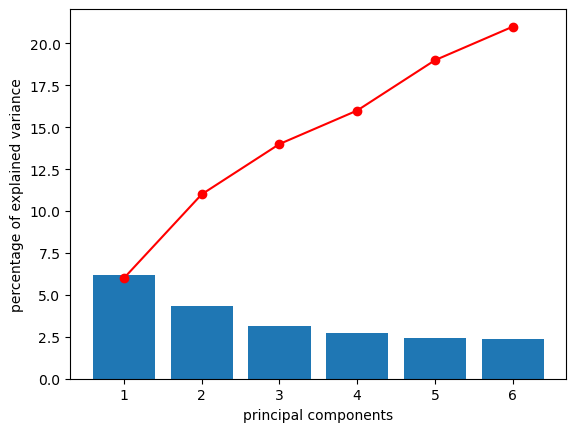

In [497]:
x_list = range(1, n_components+1)
list(x_list)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("principal components")
plt.ylabel("percentage of explained variance")
plt.show(block=False)

The variance is "low" in every component, we can therefore conclude that no linear combination of variables can explain much variability

# Feature importance

Let's explore the feature importance methods of different models to compose an array of the most optimal features.

## Logistic Regression

In [87]:
lr_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 2.5,
        'should_normalize_columns': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': non_corr_features_common,
        'should_normalize_distribution': False,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': 'balanced'
        }
    }
}

Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


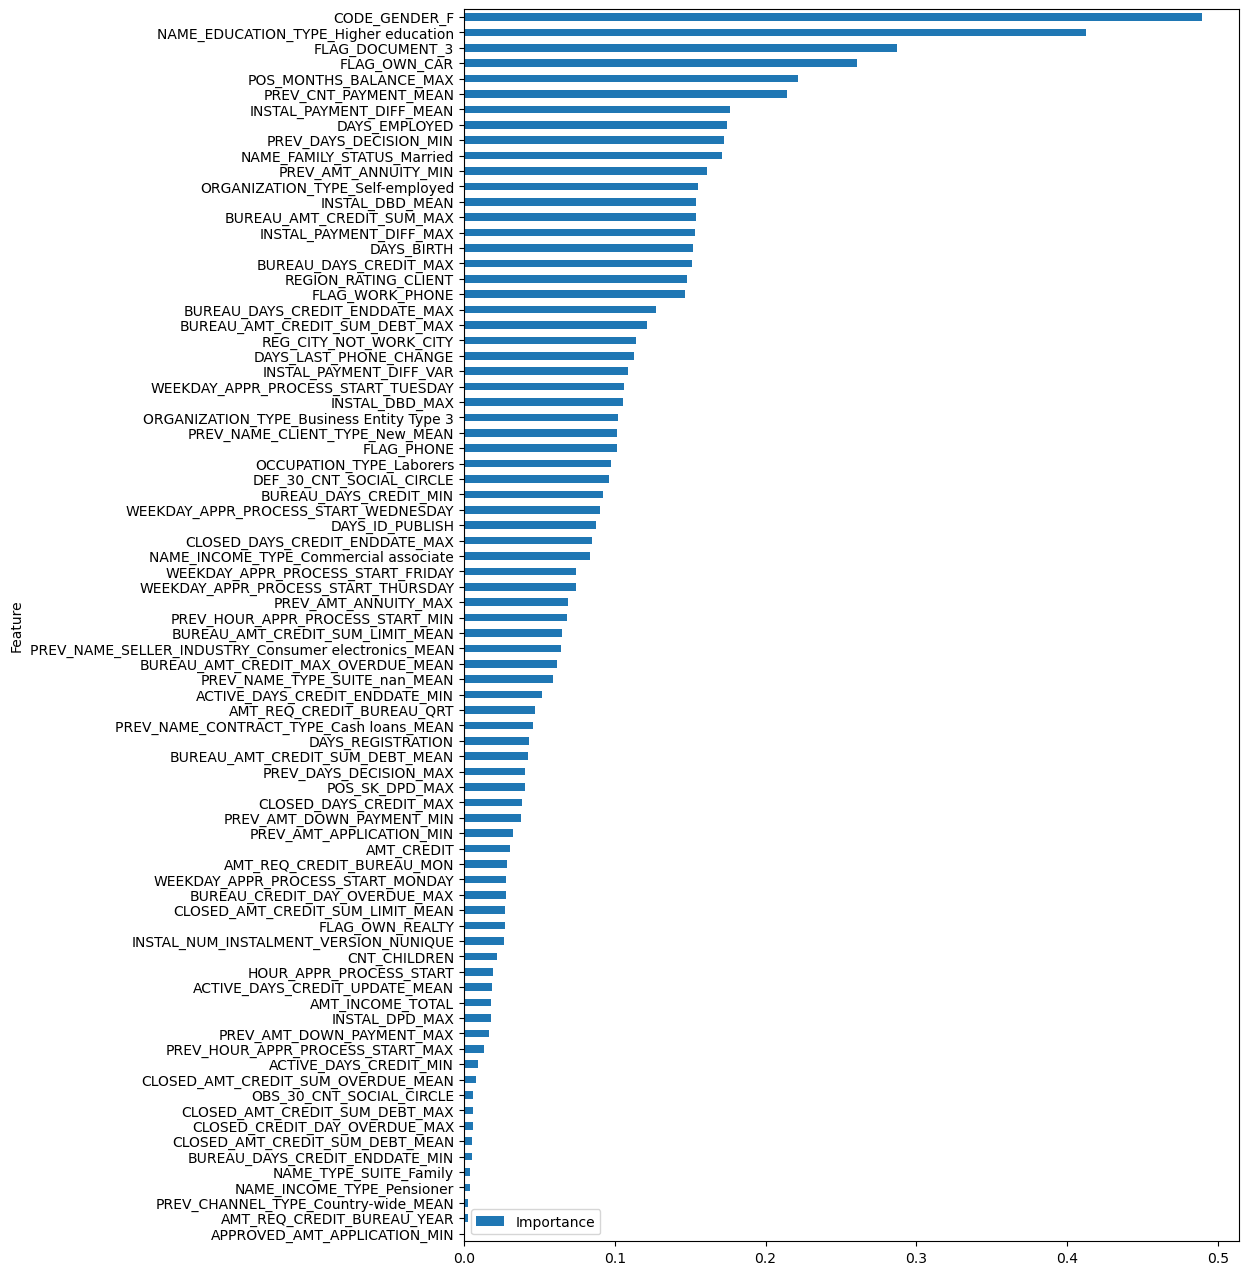

execution time: 73.57 seconds 



In [88]:
dev_mode = False
time_start = time.time()

data = process.load_application(dev_mode=dev_mode)

X = data.drop(process.TARGET_COLUMN, axis=1)
y = data[process.TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(y_train.shape))

pipeline = PIPELINES['log_regression'](config=lr_config, dev_mode=dev_mode)

print('Start pipeline fit and transform')

pipeline.fit(X_train, y_train)

# features coef
model = pipeline.named_steps["classifier"]
lr_feature_names = pipeline.named_steps["preprocessor"].transform(X_train).columns

coefficients = model.coef_[0]

lr_feature_importance = pd.DataFrame({'Feature': lr_feature_names, 'Importance': np.abs(coefficients)})
lr_feature_importance = lr_feature_importance.sort_values('Importance', ascending=True)
lr_feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 16))
plt.show()
    
exec_time = round((time.time() - time_start), 2)
print(f'execution time: {exec_time} seconds \n')

## LightGBM

In [83]:
lightGBM_config = {
   'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': True,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': non_corr_features_common,
        'should_normalize_distribution': False,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'n_estimators': 100,
            'num_leaves': 31,
            'max_depth': -1,
            'learning_rate': 0.1,
            'colsample_bytree': 1.0,
            'subsample': 1.0,
            'reg_alpha': 0,
            'reg_lambda': 0,
            'min_split_gain': 0,
            'min_child_weight': 1e-3,
            'class_weight': 'balanced'
        }
    }
}

In [84]:
dev_mode = False
time_start = time.time()

data = process.load_application(dev_mode=dev_mode)

X = data.drop(process.TARGET_COLUMN, axis=1)
y = data[process.TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(y_train.shape))

lgbm_pipeline = PIPELINES['lightGBM'](config=lightGBM_config, dev_mode=dev_mode)

print('Start pipeline fit and transform')
lgbm_pipeline.fit(X_train, y_train)

# features coef
lgbm_model = lgbm_pipeline.named_steps["classifier"]
lgbm_feature_names = lgbm_pipeline.named_steps["preprocessor"].transform(X_train).columns
    
exec_time = round((time.time() - time_start), 2)
print(f'execution time: {exec_time} seconds \n')

Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16870
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
execution time: 59.98 seconds 



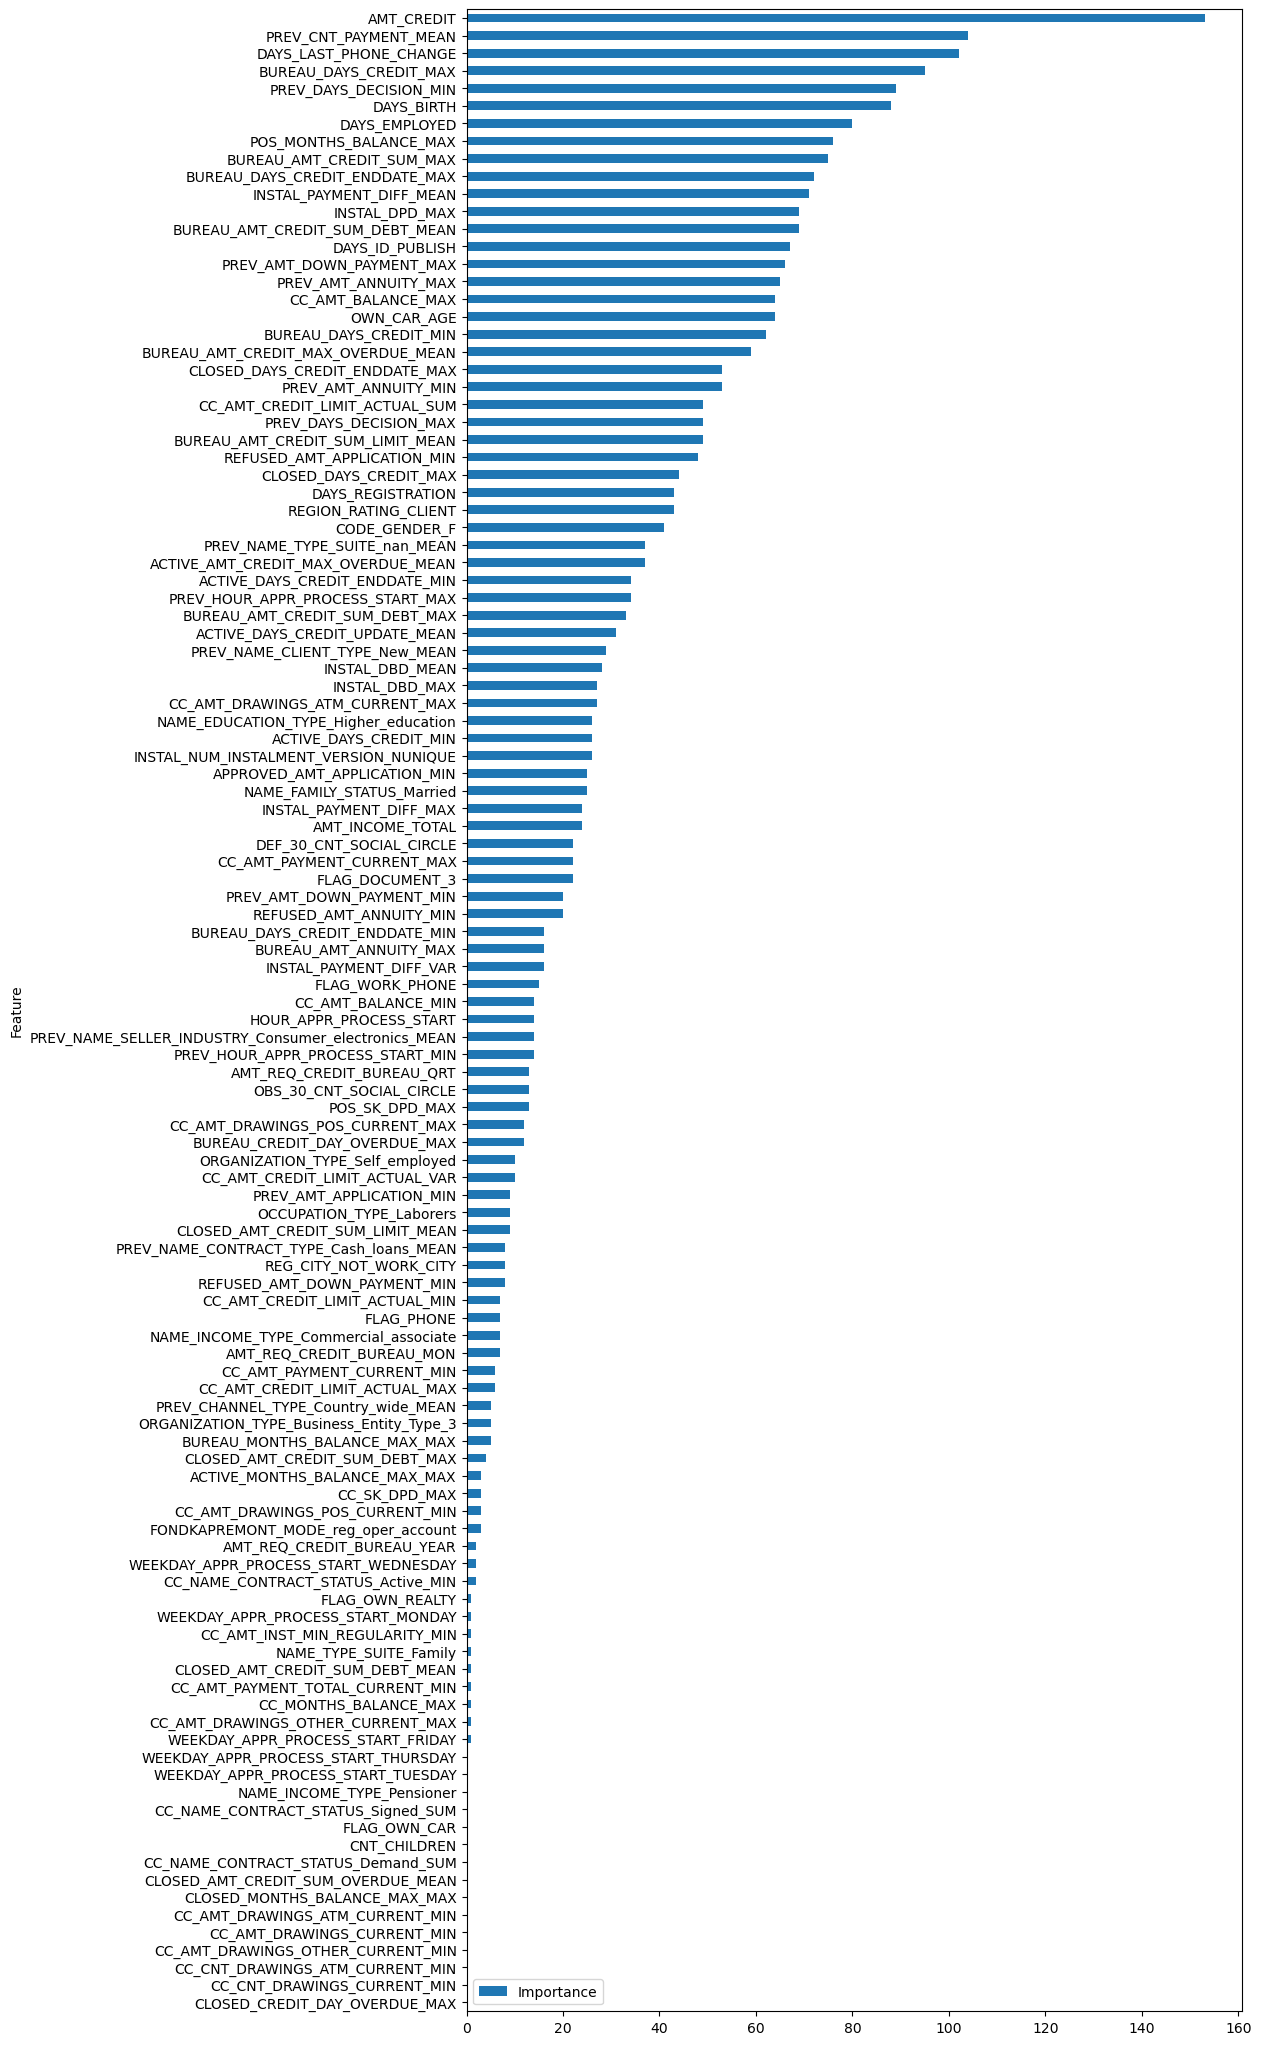

In [86]:
feature_importance = pd.DataFrame({'Feature': lgbm_feature_names, 'Importance': lgbm_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 26))
plt.show()

## XGBoost

In [101]:
xgboost_config = {
   'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'should_normalize_columns': False,
        'should_downcast': True,
        'should_select_features': True,
        'features_to_keep': non_corr_features_common,
        'should_normalize_distribution': False,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
         'params': {
            'eta': 0.3,
            'max_depth': 6,
            'colsample_bytree': 1.0,
            'subsample': 1,
            'scale_pos_weight': 11
        }
    }
}

In [102]:
from xgboost import plot_importance

dev_mode = False
time_start = time.time()

data = process.load_application(dev_mode=dev_mode)

X = data.drop(process.TARGET_COLUMN, axis=1)
y = data[process.TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(y_train.shape))

xgb_pipeline = PIPELINES['XGBoost'](config=xgboost_config, dev_mode=dev_mode)

print('Start pipeline fit and transform')

xgb_pipeline.fit(X_train, y_train)

# features coef
xgb_model = xgb_pipeline.named_steps["classifier"]
xgb_feature_names = xgb_pipeline.named_steps["preprocessor"].transform(X_train).columns

exec_time = round((time.time() - time_start), 2)
print(f'execution time: {exec_time} seconds \n')

Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
execution time: 77.16 seconds 



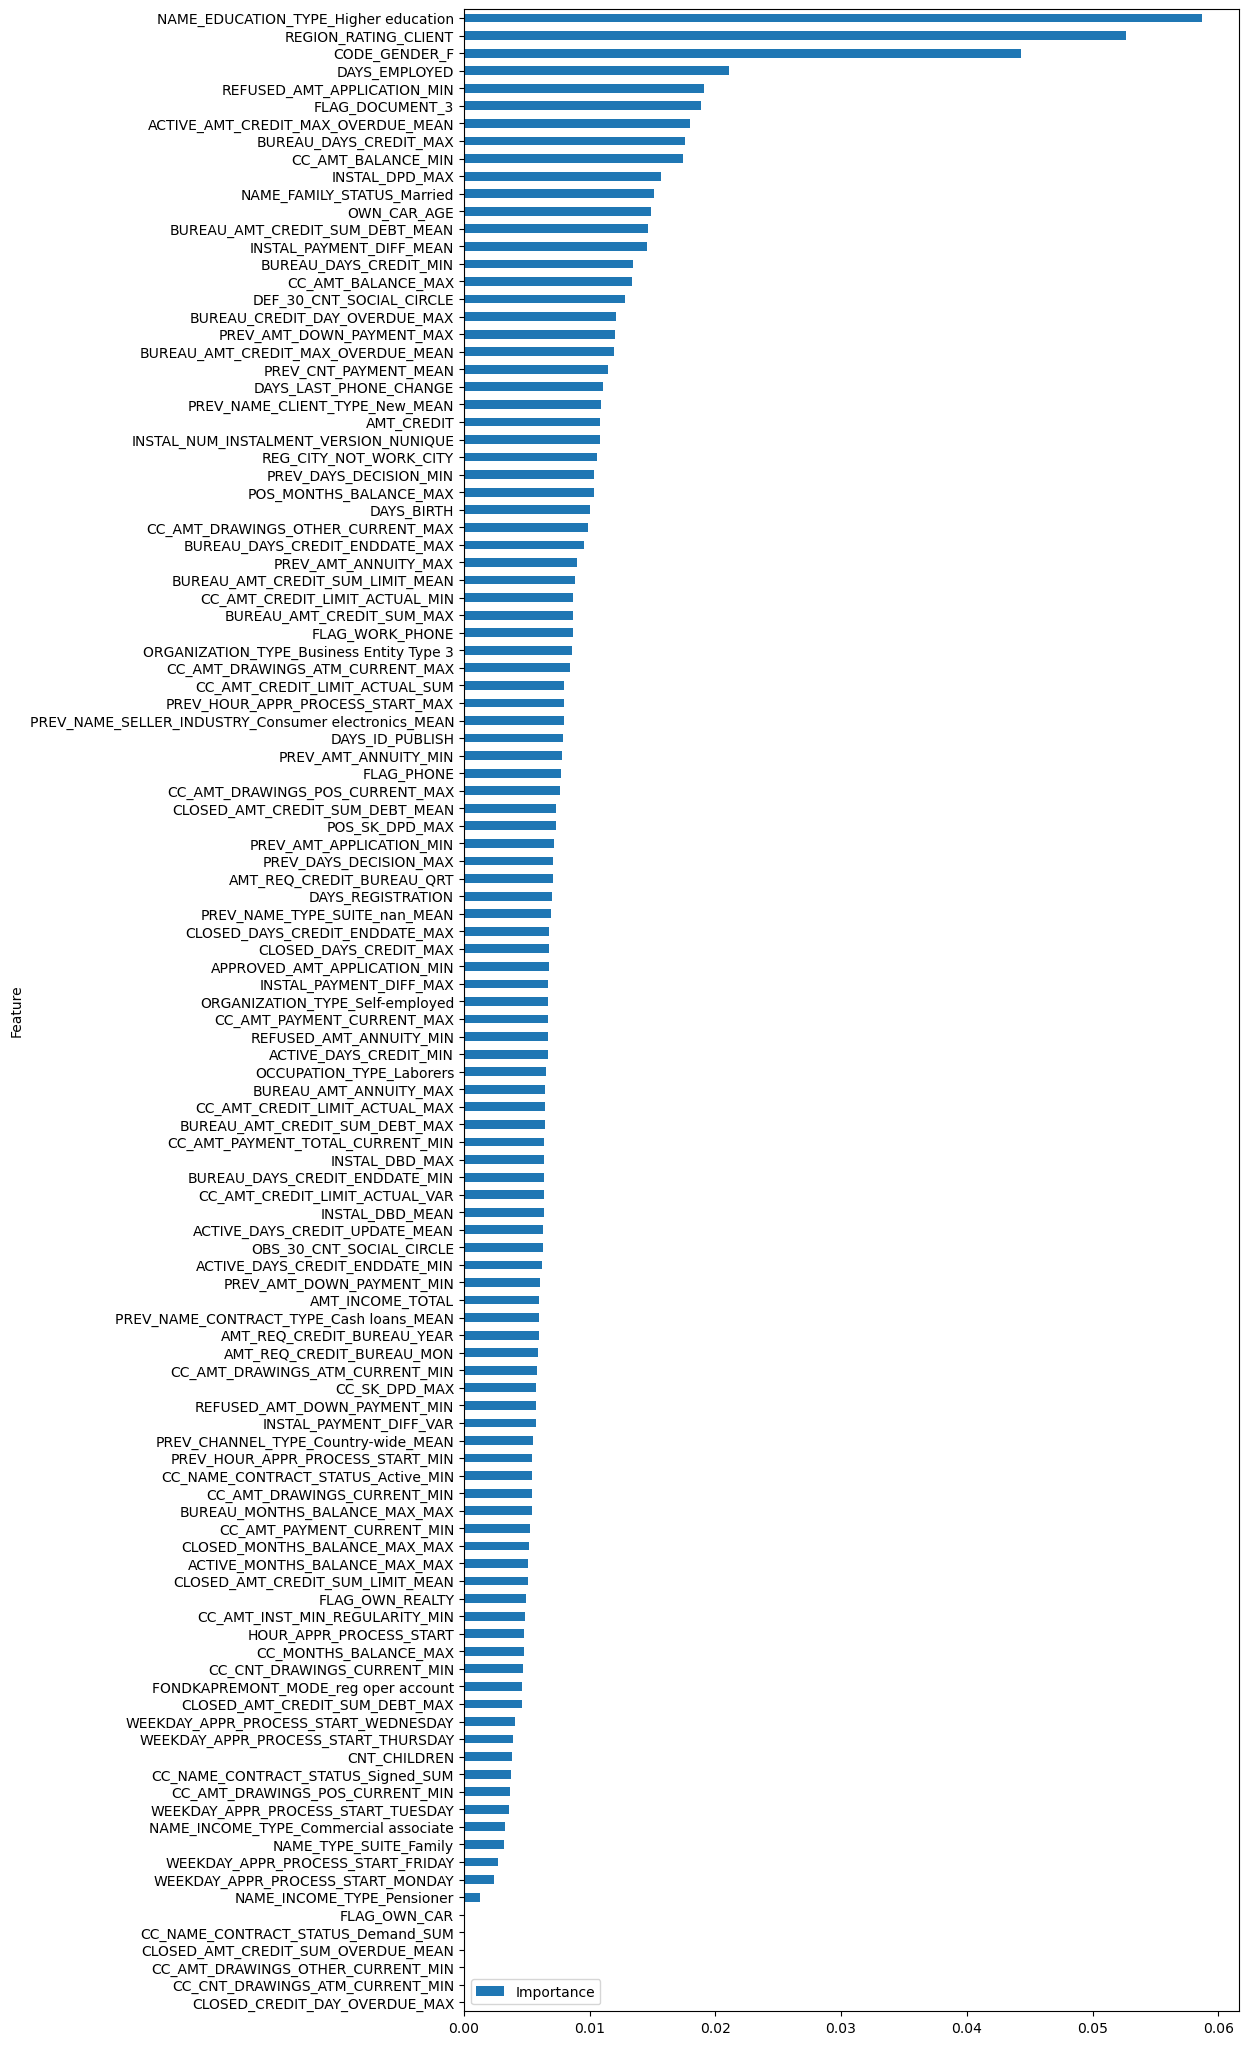

In [103]:
xgb_feature_importance = pd.DataFrame({'Feature': xgb_feature_names, 'Importance': xgb_model.feature_importances_})
xgb_feature_importance = xgb_feature_importance.sort_values('Importance', ascending=True)
xgb_feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 26))
plt.show()

## Selecting features

We will proceed as following:
- create the 1st list by selecting the 30 best features for each model and choosing the common feature among them
- make the 2nd list by taking 12 most important features for each model
- merge the 2 lists with a union

In [95]:
lr_features = list(lr_feature_importance.sort_values('Importance', ascending=False)['Feature'][:30])
lr_features

['CODE_GENDER_F',
 'NAME_EDUCATION_TYPE_Higher education',
 'FLAG_DOCUMENT_3',
 'FLAG_OWN_CAR',
 'POS_MONTHS_BALANCE_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'DAYS_EMPLOYED',
 'PREV_DAYS_DECISION_MIN',
 'NAME_FAMILY_STATUS_Married',
 'PREV_AMT_ANNUITY_MIN',
 'ORGANIZATION_TYPE_Self-employed',
 'INSTAL_DBD_MEAN',
 'BUREAU_AMT_CREDIT_SUM_MAX',
 'INSTAL_PAYMENT_DIFF_MAX',
 'DAYS_BIRTH',
 'BUREAU_DAYS_CREDIT_MAX',
 'REGION_RATING_CLIENT',
 'FLAG_WORK_PHONE',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
 'REG_CITY_NOT_WORK_CITY',
 'DAYS_LAST_PHONE_CHANGE',
 'INSTAL_PAYMENT_DIFF_VAR',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'INSTAL_DBD_MAX',
 'ORGANIZATION_TYPE_Business Entity Type 3',
 'PREV_NAME_CLIENT_TYPE_New_MEAN',
 'FLAG_PHONE',
 'OCCUPATION_TYPE_Laborers']

In [94]:
lgbm_features = list(feature_importance.sort_values('Importance', ascending=False)['Feature'][:30])
lgbm_features

['AMT_CREDIT',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'BUREAU_DAYS_CREDIT_MAX',
 'PREV_DAYS_DECISION_MIN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'POS_MONTHS_BALANCE_MAX',
 'BUREAU_AMT_CREDIT_SUM_MAX',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_DPD_MAX',
 'DAYS_ID_PUBLISH',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_AMT_ANNUITY_MAX',
 'CC_AMT_BALANCE_MAX',
 'OWN_CAR_AGE',
 'BUREAU_DAYS_CREDIT_MIN',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'PREV_AMT_ANNUITY_MIN',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_SUM',
 'PREV_DAYS_DECISION_MAX',
 'BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN',
 'REFUSED_AMT_APPLICATION_MIN',
 'CLOSED_DAYS_CREDIT_MAX',
 'REGION_RATING_CLIENT',
 'DAYS_REGISTRATION',
 'CODE_GENDER_F']

In [104]:
xgb_features = list(xgb_feature_importance.sort_values('Importance', ascending=False)['Feature'][:30])
xgb_features

['NAME_EDUCATION_TYPE_Higher education',
 'REGION_RATING_CLIENT',
 'CODE_GENDER_F',
 'DAYS_EMPLOYED',
 'REFUSED_AMT_APPLICATION_MIN',
 'FLAG_DOCUMENT_3',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BUREAU_DAYS_CREDIT_MAX',
 'CC_AMT_BALANCE_MIN',
 'INSTAL_DPD_MAX',
 'NAME_FAMILY_STATUS_Married',
 'OWN_CAR_AGE',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'BUREAU_DAYS_CREDIT_MIN',
 'CC_AMT_BALANCE_MAX',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'BUREAU_CREDIT_DAY_OVERDUE_MAX',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'PREV_CNT_PAYMENT_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'PREV_NAME_CLIENT_TYPE_New_MEAN',
 'AMT_CREDIT',
 'INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE',
 'REG_CITY_NOT_WORK_CITY',
 'PREV_DAYS_DECISION_MIN',
 'POS_MONTHS_BALANCE_MAX',
 'DAYS_BIRTH',
 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX']

In [105]:
common_features = intersection(lr_features, lgbm_features)
common_features = intersection(common_features, xgb_features)
print(len(common_features))
common_features

10


['CODE_GENDER_F',
 'POS_MONTHS_BALANCE_MAX',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'DAYS_EMPLOYED',
 'PREV_DAYS_DECISION_MIN',
 'DAYS_BIRTH',
 'BUREAU_DAYS_CREDIT_MAX',
 'REGION_RATING_CLIENT',
 'DAYS_LAST_PHONE_CHANGE']

In [107]:
all_features = union(lr_features, lgbm_features)
all_features = union(all_features, xgb_features)
print(len(all_features))
all_features

53


['BUREAU_AMT_CREDIT_SUM_LIMIT_MEAN',
 'CC_AMT_BALANCE_MIN',
 'OWN_CAR_AGE',
 'WEEKDAY_APPR_PROCESS_START_TUESDAY',
 'ORGANIZATION_TYPE_Business Entity Type 3',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MAX',
 'BUREAU_CREDIT_DAY_OVERDUE_MAX',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'INSTAL_PAYMENT_DIFF_VAR',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'NAME_EDUCATION_TYPE_Higher education',
 'BUREAU_DAYS_CREDIT_MIN',
 'INSTAL_DBD_MAX',
 'FLAG_DOCUMENT_3',
 'INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE',
 'INSTAL_PAYMENT_DIFF_MAX',
 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX',
 'NAME_FAMILY_STATUS_Married',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_REGISTRATION',
 'DAYS_LAST_PHONE_CHANGE',
 'REG_CITY_NOT_WORK_CITY',
 'POS_MONTHS_BALANCE_MAX',
 'FLAG_WORK_PHONE',
 'FLAG_OWN_CAR',
 'PREV_CNT_PAYMENT_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_DAYS_DECISION_MIN',
 'PREV_AMT_ANNUITY_MIN',
 'BUREAU_AMT_CREDIT_SUM_MAX',
 'AMT_CREDIT',
 'CODE_GENDER_F',
 'INSTAL_DBD

**Take 12 first features for each list**

In [108]:
first_features = union(lr_features[:12], lgbm_features[:12])
first_features = union(first_features, xgb_features[:12])
print(len(first_features))
first_features

25


['FLAG_DOCUMENT_3',
 'FLAG_OWN_CAR',
 'PREV_CNT_PAYMENT_MEAN',
 'CC_AMT_BALANCE_MIN',
 'OWN_CAR_AGE',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'PREV_DAYS_DECISION_MIN',
 'PREV_AMT_ANNUITY_MIN',
 'BUREAU_AMT_CREDIT_SUM_MAX',
 'AMT_CREDIT',
 'CODE_GENDER_F',
 'DAYS_BIRTH',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'DAYS_EMPLOYED',
 'NAME_FAMILY_STATUS_Married',
 'POS_MONTHS_BALANCE_MAX',
 'DAYS_LAST_PHONE_CHANGE',
 'INSTAL_DPD_MAX',
 'REFUSED_AMT_APPLICATION_MIN',
 'REGION_RATING_CLIENT',
 'ORGANIZATION_TYPE_Self-employed',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'BUREAU_DAYS_CREDIT_MAX',
 'NAME_EDUCATION_TYPE_Higher education']

**Merge with the common features**

In [110]:
final_features = union(first_features, common_features)
print(len(final_features))
final_features

25


['FLAG_DOCUMENT_3',
 'FLAG_OWN_CAR',
 'PREV_CNT_PAYMENT_MEAN',
 'CC_AMT_BALANCE_MIN',
 'OWN_CAR_AGE',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'PREV_DAYS_DECISION_MIN',
 'PREV_AMT_ANNUITY_MIN',
 'BUREAU_AMT_CREDIT_SUM_MAX',
 'AMT_CREDIT',
 'CODE_GENDER_F',
 'DAYS_BIRTH',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'INSTAL_DPD_MAX',
 'DAYS_EMPLOYED',
 'NAME_FAMILY_STATUS_Married',
 'DAYS_LAST_PHONE_CHANGE',
 'POS_MONTHS_BALANCE_MAX',
 'REFUSED_AMT_APPLICATION_MIN',
 'REGION_RATING_CLIENT',
 'ORGANIZATION_TYPE_Self-employed',
 'BUREAU_AMT_CREDIT_SUM_DEBT_MEAN',
 'BUREAU_DAYS_CREDIT_MAX',
 'NAME_EDUCATION_TYPE_Higher education']

We finally obtained 25 most important features that we will use for the training.